In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
import os

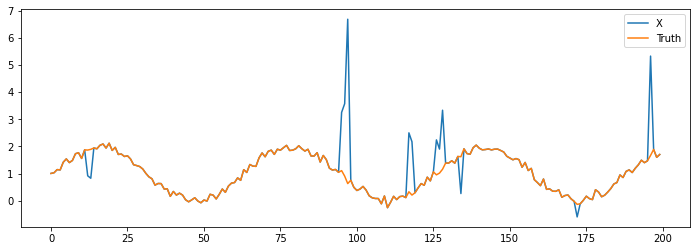

In [3]:
sample = pd.read_csv('../data/sample3.csv')
plt.figure(figsize=(12, 4))
sample[:200].plot(ax=plt.gca())
plt.show()

In [4]:
decomposition = seasonal_decompose(sample.X, model='additive', period = 20)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

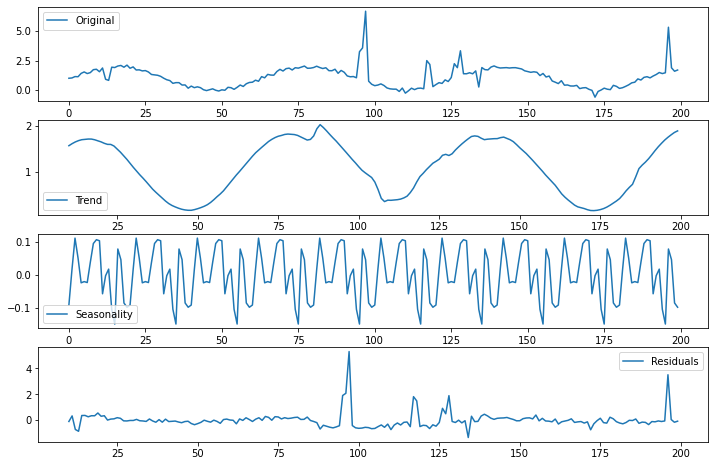

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(sample.X[:200], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[:200], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[:200],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[:200], label='Residuals')
plt.legend(loc='best')
plt.show()

# DBSCAN

In [24]:
def dbscan_diff(X):
    
    n = 1000 # number of observations for fitting
    X_clean = X.copy()
    
    for i in range(3):
    
        # calculate diff
        decomposition = seasonal_decompose(X_clean, model='additive', period = 20)

        X_diff = decomposition.resid.copy()
        X_diff = pd.Series(X_diff).fillna(0).values
        X_diff = X_diff / np.linalg.norm(X_diff)
        X_diff = np.reshape(X_diff, (X_diff.shape[0], 1))

        # fit eps
        eps_space = np.linspace(0.00001, 0.00025, 100)
        cluster_size = []
        for eps in eps_space:
            dbscan = DBSCAN(eps=eps).fit(X_diff[:n])
            largest_size = 0
            for label in set(dbscan.labels_):
                len_set = (dbscan.labels_ == label).sum()
                if largest_size < len_set:
                    largest_size = len_set
            cluster_size.append(largest_size / n * 100)
        cluster_size = np.array(cluster_size)
        best_eps = eps_space[np.argmax(cluster_size[1:] - cluster_size[:-1]) + 1]

        # clustering
        dbscan = DBSCAN(eps=best_eps).fit(X_diff)

        # updating
        largest_size = 0
        largest_cluster = None
        for label in set(dbscan.labels_):
            len_set = (dbscan.labels_ == label).sum()
            if largest_size < len_set:
                largest_size = len_set
                largest_cluster = label

        X_clean[dbscan.labels_ != largest_cluster] = None
        X_clean = pd.Series(X_clean).interpolate().values
        X_clean = pd.Series(X_clean).fillna(0).values

    return X_clean

In [25]:
def get_files_list(path):
    files = []
    for aname in os.listdir(path):
        if (aname[-3:] == "csv") or (aname[-3:] == "txt"): 
            files.append(os.path.join(path, aname))
    return files

def run_tests(dir_path):
    
    print("Dataset: ", dir_path)
    files = get_files_list(dir_path)
    files.sort()
    
    report = pd.DataFrame(columns=["Sample", "RMSE"])
    
    for afile in files:
        
        print("File: ", afile)
            
        data = pd.read_csv(afile, index_col=False)
        
        X      = data['X'].values
        X_true = data['Truth'].values
        
        X_clean = dbscan_diff(X)
        
        rmse = mean_squared_error(X_true, X_clean, squared=False)
        
        report.loc[len(report)] = [afile, rmse]
        print("RMSE: ", rmse)
            
    return report

In [28]:
report = run_tests('../data/')
report

Dataset:  ../data/
File:  ../data/sample1.csv
RMSE:  0.16994966454880886
File:  ../data/sample2.csv
RMSE:  0.1514384190707298
File:  ../data/sample3.csv
RMSE:  0.20868123852991474
File:  ../data/sample4.csv
RMSE:  0.8032579670184282
File:  ../data/sample5.csv
RMSE:  0.22770572986834647
File:  ../data/sample6.csv
RMSE:  2.804203571362004
File:  ../data/sample7.csv
RMSE:  7.397959752626424
File:  ../data/sample8.csv
RMSE:  0.7222244612817394
File:  ../data/sample9.csv
RMSE:  81.8244875326816


Sample       RMSE
0  ../data/sample1.csv   0.169950
1  ../data/sample2.csv   0.151438
2  ../data/sample3.csv   0.208681
3  ../data/sample4.csv   0.803258
4  ../data/sample5.csv   0.227706
5  ../data/sample6.csv   2.804204
6  ../data/sample7.csv   7.397960
7  ../data/sample8.csv   0.722224
8  ../data/sample9.csv  81.824488

# Models Comparison

In [31]:
board = pd.DataFrame(columns=['Data preparation', 'Model']+['sample'+str(i) for i in range(1, 10)])
board.loc[len(board)] = ['Additive decomposition', 'DBSCAN'] + list(report['RMSE'].values)
board = board.set_index(['Data preparation', 'Model'])
board

sample1   sample2   sample3   sample4  \
Data preparation       Model                                           
Additive decomposition DBSCAN  0.16995  0.151438  0.208681  0.803258   

                                sample5   sample6  sample7   sample8  \
Data preparation       Model                                           
Additive decomposition DBSCAN  0.227706  2.804204  7.39796  0.722224   

                                 sample9  
Data preparation       Model              
Additive decomposition DBSCAN  81.824488

In [32]:
board.iloc[[0], :].to_csv('../results/add_dec_dbscan.csv')